# Training Tips

**Prerequisites**

- Tensorflow
- SGD
- MLP

**Outcomes**

- Understand the arguments to the keras `.fit` method
- Be able to use tensorboard to track training progress
- Be able to save a trained model and load it from disk for prediction
- Introduce concept of transfer learning

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

## Practical Keras

- We've done some heavy lifting on math side
- Now let's add in a touch of practicality and go over some best practices and features of using keras


### Dataset

- The exact problem we are solving isn't extremely relevant here as our focus is on the techniques
- That being said, we may as well have fun while we are at it!
- This dataset is called "Fashion MNIST"

### Fashion MNIST

- Once MNIST was too easy for new ML models and algorithms, the researchers in the field created a new challenge: [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)
- Instead of pictures of hand written digits, the Fashion MNIST dataset contains low-resolution images of articles of clothing

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


4431872/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


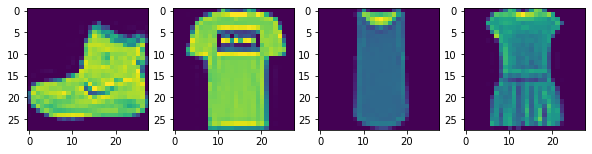

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

fig, ax = plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    ax[i].imshow(x_train[i, :, :, 0])

- Let's also define a helper function that will let us quickly define a new model so we can experiment later on

In [3]:
def build_model():
    # 1. define model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation="softmax")
    ])

    # 2 compile model (choose optimizer and loss)
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

model = build_model()

## Arguments to`.fit`

- Keras is a very powerful and flexible framework
- This is necessary to handle the breadth of ML tasks the modern researcher has to perform
- A lot of the flexibility is in the fit method
    - `batch_size`
    - `class_weight` and `sample_weight` for imbalanced datasets
    - `initial_epoch` to continue training
    - `validation_split` if we want keras to split for us
    
Reference: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fitReference: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

## Tensorboard

- On large problems (either in number of observations or size of network), training can take a very long time
- Sometimes it is helpful to be able to monitor the progress of training
- Tensorflow has a built-in feature called tensorboard that allows you to see a live dashboard of training as it is happening

### Tensorboard with Keras

- When using keras, it is very easy to integrate tensorboard
- There are three main concepts:
    1. Choose a directory for keras to write "logs"
    2. Set up the tensorboard callback for the `.fit` method
    3. Start tensorboard and point it at logs directory


We'll start the training below and load up tensorboard at the same time

> Note: there is much more you can do with tensorboard... we are only covering the basics. Check out their [docs](https://www.tensorflow.org/tensorboard) for more ideas and details

In [4]:
# step 1, choose logs directory
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H_%M")
log_dir = "fashion_mnist_logs/fit/{}".format(timestamp)

# step 2. set up callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# step 3. fit model
model.fit(x=x_train, 
          y=y_train, 
          epochs=30, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/30
1875/1875 [==============================] - 11s 5ms/step - loss: 0.5071 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.4375 - val_sparse_categorical_accuracy: 0.8460
Epoch 2/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3785 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.3837 - val_sparse_categorical_accuracy: 0.8641
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3451 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.3898 - val_sparse_categorical_accuracy: 0.8683
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3281 - sparse_categorical_accuracy: 0.8826 - val_loss: 0.4148 - val_sparse_categorical_accuracy: 0.8620
Epoch 5/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3157 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.3745 - val_sparse_categorical_accuracy: 0.8737
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3079 - spa

## Using our models 

- Now that we have fit our model, let's use it!

### Prediction (inference)

- We can predict the label for new images using the `.predict` method
- Using a trained model to make a prediction is called prediction, or sometimes by the deep learning community "inference"

In [5]:
model.predict(x_test[3:4])

array([[7.0723240e-13, 1.0000000e+00, 9.4608033e-24, 1.0103242e-11,
        1.9663989e-24, 1.0154721e-31, 2.7607355e-19, 0.0000000e+00,
        2.0640438e-29, 3.7758777e-29]], dtype=float32)

- In this case the model seems very confident that the correct label is `1`
- From the table above, the label `1` corresponds to "Trouser"
- Let's see what the image looked like and what the true label is

1


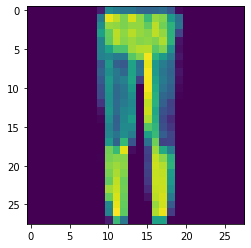

In [6]:
plt.imshow(x_test[3])
print(y_test[3])

- Sure enough -- looks like pants and that's what the target was

### Saving and Loading Models

- When using a machine learning in practice, we often need to train it in one python Session and use it somewhere else
- This will require that we can effectively save and load a model to a hard disk
- The `model.save` function will do just this

In [7]:
!ls

01_backprop.ipynb            fashion_mnist_logs
02_training_with_keras.ipynb


In [8]:
model.save("fashion_mnist_model.h5")
!ls

01_backprop.ipynb            fashion_mnist_logs
02_training_with_keras.ipynb fashion_mnist_model.h5


In [9]:
loaded_model = keras.models.load_model("fashion_mnist_model.h5")

In [10]:
loaded_model.predict(x_test[3:4])

array([[7.0723240e-13, 1.0000000e+00, 9.4608033e-24, 1.0103242e-11,
        1.9663989e-24, 1.0154721e-31, 2.7607355e-19, 0.0000000e+00,
        2.0640438e-29, 3.7758777e-29]], dtype=float32)

## Transfer Learning

- There are a few sub-problems in ML that are very well studied
- You might even say they are mostly "solved"
- One of this is image recognition -- we'll focus on this subproblem for the next few minutes
- Question: can we leverage models trained on one dataset for prediction on another?

### Network Intuitions

- Because of the nested functions and many parameters, it is difficult to tell exactly why a neural network does what it does
- It is somewhat of a "black box"
- However, some work has been done to support a hypothesis that a network works as follows:
    - Early layers in the network learn basic features: e.g. how to recognize a line, how to find the color red
    - Subsequent layers know how to combine multiple basic features: a red line, or two lines that intersect at a right angle
    - Later layers in the network combine the more advanced features into sophisticated representations: a long straight line with a red-eight sided polygon on top of it (a US stop sign)

### Transfer Learning

- Because early layers find general features that appear in most images, the weights/biases they learn can be useful across problem domains:
    - Dogs vs cats
    - Digits
    - Find your friends in a photo
- Later layers use these generally applicable learned representations to tailor predictions to a task
- This is the idea behind transfer learning: use an expertly crafted and trained neural network for your own task (even if it was trained for a different task of the same type)

### Example: MobileNet

- Typically, models that achieve state of the art performance are given names
- One such model is called `MobileNet`
- This model is famous because it has excellent performance, but is relatively small (compared to other modern neural networks) and thus applicable for mobile devices
- Let's apply `MobileNet` on our Fashion MNIST example

#### Transfer learning strategy

1. Define the shape of our data (28, 28, 1) -- necessary b/c MobileNet was trained images of a different size
2. Load model, without final layer for predictions. Freeze all weights
3. Add a `Dense(10)` layer to end of network for our problem
4. Train our layer

> Note: don't focus on code here -- just focus on the fact that this is possible. It is pretty incredible!

In [11]:
# step 1. define shapes
input_image = keras.layers.Input(shape=(28, 28, 3))
resized_image = keras.layers.Lambda(lambda image: keras.backend.resize_images(x=image, height_factor=2, width_factor=2, data_format='channels_last'))(input_image)

# step 2. load model. set weights to fixed
base_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_tensor=resized_image)

# don't change parameters of the MobileNet model
base_model.trainable = False

# step 3. add some layers
x = base_model.output
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)

# build model
transfer_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

9420800/9406464 [==============================] - 1s 0us/step


In [12]:
# step 4. fit our layers
transfer_model.compile(
    optimizer='rmsprop', 
    loss='sparse_categorical_crossentropy', 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

log_dir = "fashion_mnist_logs/mobilenet/fit/{}".format(timestamp)

# step 2. set up callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


transfer_history = transfer_model.fit(
    np.repeat(x_train, 3, -1), y_train, 
    epochs=30, 
    validation_data=(np.repeat(x_test, 3, -1), y_test),
    callbacks=[tensorboard_callback]
)

Epoch 1/30
1875/1875 [==============================] - 218s 113ms/step - loss: 0.5604 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.4467 - val_sparse_categorical_accuracy: 0.8495
Epoch 2/30
1875/1875 [==============================] - 172s 92ms/step - loss: 0.4662 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.4607 - val_sparse_categorical_accuracy: 0.8548
Epoch 3/30
1875/1875 [==============================] - 182s 97ms/step - loss: 0.4685 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.4510 - val_sparse_categorical_accuracy: 0.8583
Epoch 4/30
1875/1875 [==============================] - 256s 136ms/step - loss: 0.4689 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.4585 - val_sparse_categorical_accuracy: 0.8605
Epoch 5/30
1875/1875 [==============================] - 181s 96ms/step - loss: 0.4710 - sparse_categorical_accuracy: 0.8556 - val_loss: 0.4893 - val_sparse_categorical_accuracy: 0.8527
Epoch 6/30
1875/1875 [==============================] - 202s 108ms/step -